In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from icecream import ic

In [14]:
# import data from ../data/data-agg.csv 
data = pd.read_csv('../data/data-agg.csv')
print(len(data[data['coin']=='2HRK']))

# fill the table with the other relevant values 
data['rom_heads'] = data['heads_heads']/data['N_start_heads_up']
data['rom_tails'] = (data['N_start_tails_up']-data['tails_heads'])/data['N_start_tails_up']

print(len(data))

# duplicate data : 
data_expanded = pd.concat([
    data.assign(heads_indicator=1),
    data.assign(heads_indicator=0)
])
data_expanded = data_expanded.reset_index(drop=True)

# the function that will select the right r based on the indicator heads indicator : 
def get_r(row):
    if row['heads_indicator'] == 1:
        return row['heads_heads']
    else:
        return row['N_start_tails_up'] - row['tails_heads']
# the function that will select the right m based on the indicator heads indicator : 
def get_m(row):
    if row['heads_indicator'] == 1:
        return row['N_start_heads_up']
    else:
        return row['N_start_tails_up']
    
data_expanded['r'] = data_expanded.apply( get_r, axis=1)
data_expanded['m'] = data_expanded.apply( get_m, axis=1)
data_expanded['rom'] = data_expanded['r'] / data_expanded['m']

print(len(data_expanded))
print(data_expanded)

1
211
422
     heads_heads  tails_heads  N_start_heads_up  N_start_tails_up  \
0            244          240               485               515   
1            260          245               505               495   
2            209          260               469               531   
3            530          495              1021               979   
4            533          507              1039               961   
..           ...          ...               ...               ...   
417          517          561              1084              1116   
418          782          844              1626              1674   
419          233          249               478               522   
420          775          746              1523              1477   
421          257          238               496               504   

           person          coin  rom_heads  rom_tails  heads_indicator    r  \
0      frantisekB  20DEM-silver   0.503093   0.533981                1  244   
1  

In [15]:
import statsmodels.api as sm 

In [16]:
# each coefficient represents the contribution of one person to the grand mean let's say. 
# we consider there are 
from statsmodels.regression import linear_model

WLS_model = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)", data=data_expanded)
result_WLS = WLS_model.fit()

table = sm.stats.anova_lm(result_WLS, typ=2) # Type 2 ANOVA DataFrame
print(result_WLS.summary())
#print(table)

                            WLS Regression Results                            
Dep. Variable:                    rom   R-squared:                       0.339
Model:                            WLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     4.084
Date:                Wed, 25 Dec 2024   Prob (F-statistic):           7.63e-15
Time:                        19:06:59   Log-Likelihood:                 1000.3
No. Observations:                 422   AIC:                            -1905.
Df Residuals:                     374   BIC:                            -1710.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

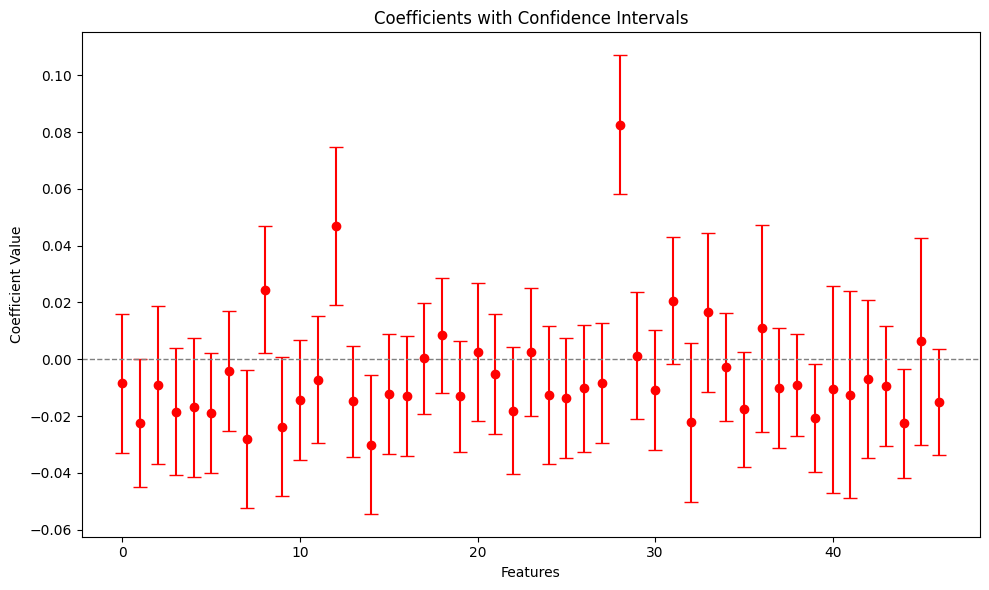

In [18]:
import re

coefficients = result_WLS.params
conf_int = result_WLS.conf_int()

# remove the constant coefficient : 
coefficients = result_WLS.params[1:]  # Exclude the first coefficient
conf_int = result_WLS.conf_int()[1:] 
conf_int_inf= list(conf_int[0])
conf_int_sup= list(conf_int[1])
feature_names = result_WLS.model.exog_names[1:]


# Determine colors based on the feature names
colors = [
    'red' if 'person' in feature else 'blue' if 'coin' in feature else None
    for feature in feature_names
]
# Create the plot
plt.figure(figsize=(10, 6))
# Clean the feature names

for i, (feature, coef, color) in enumerate(zip(feature_names, coefficients, colors)):
    plt.errorbar(
        x=i,
        y=coef,
        yerr=[[coef - conf_int_inf[i]], [conf_int_sup[i] - coef]],
        fmt='o',
        ecolor=color,  # Use the determined color for error bars
        color=color,   # Use the determined color for points
        capsize=5
    )

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Create a legend
plt.scatter([], [], color='red', label='Persons')   # Red legend entry
plt.scatter([], [], color='blue', label='Coins')    # Blue legend entry
plt.scatter([], [], color='green', label='Starting head')  # Green legend entry

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients with Confidence Intervals')
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

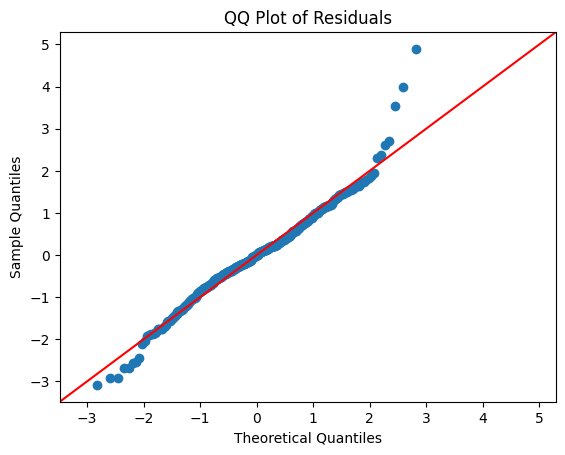

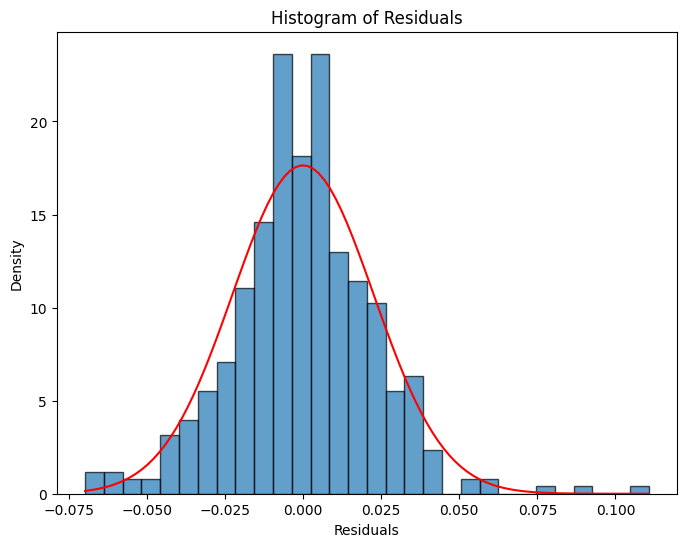

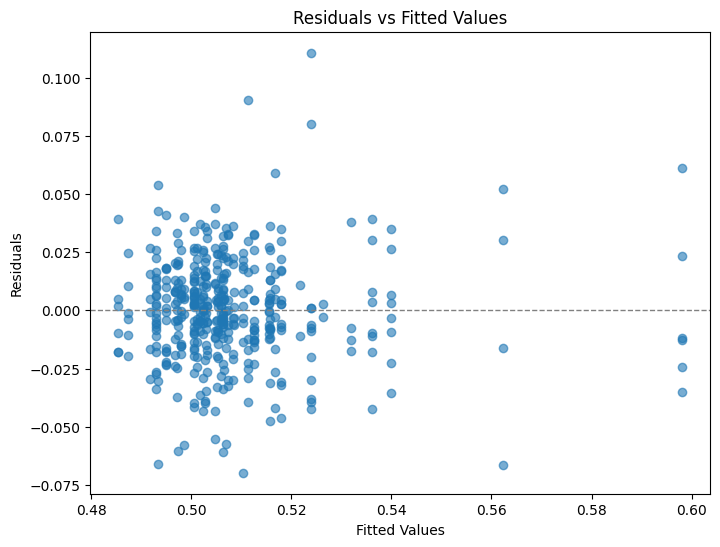

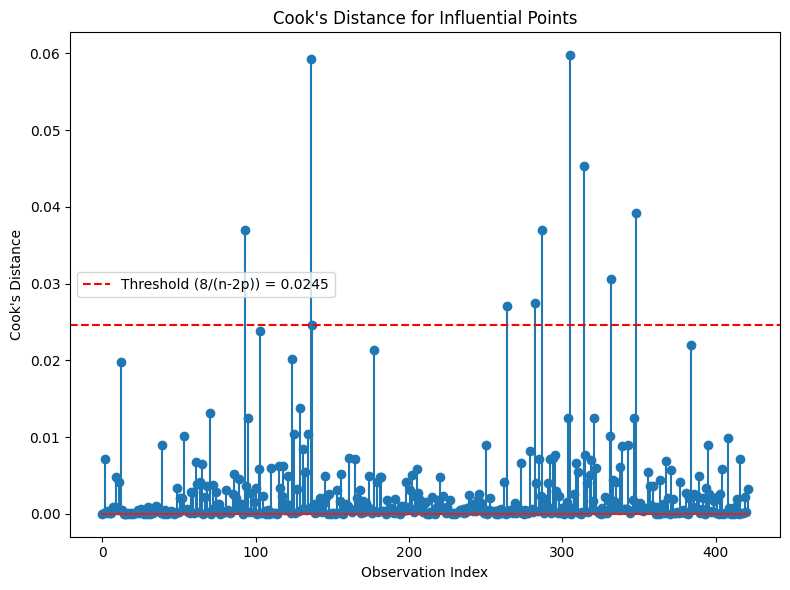

Influential points (index): [ 93 136 137 264 282 287 305 314 332 348]


In [19]:
import scipy.stats as stats

# Extract residuals and fitted values
residuals = result_WLS.resid # actual values minus the predicted value
fitted_values = result_WLS.fittedvalues # ok predicted values 
standardized_residuals = residuals / np.std(residuals) # standardized residuals 

# QQ Plot (Normality of residuals)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

# Histogram of Residuals (Check for normality)
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, density=True)
# Overlay normal distribution
x = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x, stats.norm.pdf(x, loc=np.mean(residuals), scale=np.std(residuals)), color='red')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Scale-Location Plot (Spread of residuals)
'''
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)), alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Scale-Location Plot')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.show()
'''

# ----------------------------------------------------------------------------------------------------
# COOK'S MEASURE : 
# ----------------------------------------------------------------------------------------------------
# Extract model data
X = WLS_model.exog  # Design matrix
W = np.diag(WLS_model.weights)  # Diagonal weight matrix
n = X.shape[0]  
p = X.shape[1] 

# matrix H
H = W @ X @ np.linalg.inv(X.T @ W @ X) @ X.T @ W
leverage = np.diag(H)  # diagonal of H, the hjj's in the slides

# Cook distance
standardized_residuals = residuals / np.std(residuals)
cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage))
# check :::: cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage)**2)

# Threshold for Cook's Distance
threshold = 8 / (n - 2 * p)

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d)  
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold (8/(n-2p)) = {threshold:.4f}")
plt.legend()
plt.tight_layout()
plt.show()

influential_points = np.where(cooks_d > threshold)[0] # extreme points 
print(f"Influential points (index): {influential_points}")

In [22]:
# Identify problematic points : 
number_of_extreme_points = 10

# the 2 highest values (par exemple) that we seen on the qq plot correspond to : 
largest_residuals_indices = np.argsort(np.abs(residuals))[-number_of_extreme_points:]  # Indices of the two largest (in val absolute)residuals
# go to corresponding rows in data_expanded
largest_residuals_data = data_expanded.iloc[largest_residuals_indices]
# Extract persons and coins
persons = largest_residuals_data['person'].values

# Display the results
for i, index in enumerate(largest_residuals_indices):
    print(f"Residual Index: {index}, Person: {persons[i]}, Residual Value: {residuals[index]}")


Residual Index: 124, Person: TingPan, Residual Value: 0.05886708720226841
Residual Index: 177, Person: RietvanBork, Residual Value: -0.06050236271373888
Residual Index: 2, Person: frantisekB, Residual Value: -0.06065976482836544
Residual Index: 332, Person: TianqiPeng, Residual Value: 0.06131256514769312
Residual Index: 136, Person: XiaoyiLin, Residual Value: -0.06601261559060229
Residual Index: 305, Person: JanYang, Residual Value: -0.0663126051935915
Residual Index: 384, Person: MichelleDonzallaz, Residual Value: -0.06976548208426542
Residual Index: 103, Person: MagdaMatetovici, Residual Value: 0.08021077443403501
Residual Index: 287, Person: EJ, Residual Value: 0.09043392309178355
Residual Index: 314, Person: MagdaMatetovici, Residual Value: 0.11065949238275297


In [24]:
fitted_values = result_WLS.fittedvalues

# Get the indices of the 10 highest fitted values
top_10_indices = np.argsort(fitted_values)[-10:][::-1]  # Sort in descending order and get top 10 indices

# Get the corresponding rows from the data_expanded DataFrame
top_10_data = data_expanded.iloc[top_10_indices]

# Extract persons and fitted values
top_10_persons = top_10_data['person'].values
top_10_fitted_values = fitted_values[top_10_indices]

# Display the results
print("Top 10 Highest Fitted Values and Corresponding Persons:")
for i, (person, fitted_value) in enumerate(zip(top_10_persons, top_10_fitted_values)):
    print(f"Rank {i+1}: Person: {person}, Fitted Value: {fitted_value}")


Top 10 Highest Fitted Values and Corresponding Persons:
Rank 1: Person: TianqiPeng, Fitted Value: 0.5981077247073794
Rank 2: Person: TianqiPeng, Fitted Value: 0.5981077247073794
Rank 3: Person: TianqiPeng, Fitted Value: 0.5981077247073794
Rank 4: Person: TianqiPeng, Fitted Value: 0.5981077247073794
Rank 5: Person: TianqiPeng, Fitted Value: 0.5981077247073794
Rank 6: Person: TianqiPeng, Fitted Value: 0.5981077247073794
Rank 7: Person: JanYang, Fitted Value: 0.5623338253527427
Rank 8: Person: JanYang, Fitted Value: 0.5623338253527427
Rank 9: Person: JanYang, Fitted Value: 0.5623338253527427
Rank 10: Person: JanYang, Fitted Value: 0.5623338253527427
